# Hyperparameter tuning 

Histogram Based Gradient Boosted classifiers have a number of hyper parameters that can be adjusted (see [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)). 
In early prototypes of the VRA scoring models we found that the most impactful parameters were the `l2 regularisation` and the `learning rate`, so this is what this grid search will focus on. 
Other hyperparameters are left as default. 

### The scripts
In this directory you'll see two bash scripts and two python scripts (one pair for the day1 models, another pair for the update models). They train Galactic score and Real score models for the following range of parameters:
* learning rates: (0.1, 0.2, 0.3, 0.4, 0.5)
* l2: (1, 10)

The limits of these ranges were chosen based on preliminary tests with earlier models. 

### Evaluating the models
Since our goal is to order the eyeball list as best we can, we do not chose the hyperparameters based on isolated performance metrics on the Real and Galactic scoring models. Instead we use all combinations of trained models to order the test eyeball lists, then we plot the **Recall at Rank K** and we calculated the **Area under the Recall at rank K**. The models that maximise this value are then selected as the best 

In [114]:
from atlasvras.utils.prettify import vra_colors, label_to_color
import matplotlib.pyplot as plt
import pandas as pd 
from glob import glob
from joblib import load
from tqdm.notebook import tqdm
import numpy as np

dict_type_to_preal = {'garbage': 0,
                      'pm': 0,
                      'galactic': 1,
                      'good': 1
                     }

dict_type_to_pgal = {'garbage': 0,
                      'pm': 1,
                      'galactic': 1,
                      'good': 0
                     }

############## PLOT STYLE ################
# Comment out if you don't have the file
plt.style.use('vra')
##########################################

## 1. Day 1 Models

### The data 

In [115]:
RELATIVE_PATH = '../../data/features_and_labels_csv/day1/'
X_train_unbalanced = pd.read_csv(f'{RELATIVE_PATH}X_train_unbalanced_randomsplit.csv', index_col=0)
X_test_unbalanced = pd.read_csv(f'{RELATIVE_PATH}X_test_unbalanced_randomsplit.csv', index_col=0)
y_train_unbalanced = pd.read_csv(f'{RELATIVE_PATH}y_train_unbalanced_randomsplit.csv', index_col=0)
y_test_unbalanced = pd.read_csv(f'{RELATIVE_PATH}y_test_unbalanced_randomsplit.csv', index_col=0)

X_train = pd.read_csv(f'{RELATIVE_PATH }X_train_randomsplit.csv', index_col = 0)
y_train = pd.read_csv(f'{RELATIVE_PATH }y_train_randomsplit.csv', index_col = 0)

y_train_real_unbalanced = y_train_unbalanced.map(lambda x: dict_type_to_preal[x])
y_train_gal_unbalanced = y_train_unbalanced.map(lambda x: dict_type_to_pgal[x])

y_train_real = y_train.map(lambda x: dict_type_to_preal[x])
y_train_gal = y_train.map(lambda x: dict_type_to_pgal[x])

y_test_real = y_test_unbalanced.map(lambda x: dict_type_to_preal[x])
y_test_gal = y_test_unbalanced.map(lambda x: dict_type_to_pgal[x])

### The models that were trained in our scripts.

In [116]:
real_models=sorted(glob('hp_tuning_day1/models/real*_randomsplit*'))
gal_models=sorted(glob('hp_tuning_day1/models/gal*_randomsplit*'))

### Rank function and recall at rank K

Our ranking system is based on the geomtric distance to the (Real, Extragalactic) coordinate of our score space. 
#### Ranking logic:
* 1) Calculate the geometric distance from the most (Real, Extragalctic) coordinate in the score space
    * NOTE: we also apply a scalar (or "fudge factor") to the galactic axis such that the score space is stretched along the real axis. It's a "cheap" way to  better separate the distributions of the desirable and non desriable alerts.
* 2) Normalise the ranks (by dividing by the length of the graph's diagnoal) 
* 3) Multiply by the number you think should mark the maximum rank. In our case that's 10 because we decided the values should range from 0 to 10. 

**Note:**
* The rank in a an ordered list is an integer that referes to the position of an item in this list. 
* The _VRA rank_ is **not** a rank in the typical sense . It is a **score** between 0 and 10 where 0 is "worst" and 10 is "best" which is then used to order the eyeball list. The reason it's called the _VRA rank_ is because the VRA _scores_ refer to the "Real" and "Galactic" scores (which are used to calculated the _VRA rank_). 

In [117]:
def rank_function(REAL_PRED, GAL_PRED, fudge_factor=0.5, max_rank=10):
    """
    Function that calculates the VRA ranks from the real and galactic scores predicted by the models
    
    The "fudge_factor" is a scalar applied to the galactic axis and it is set to 0.5.
    The maximum rank is the maximum value we want the VRA ranks to take. 
    """
    ranks = np.sqrt((1-REAL_PRED)**2 + fudge_factor*(GAL_PRED)**2)
    max_distance = np.sqrt(fudge_factor**2 + 1)
    return (max_distance - ranks) * max_rank / max_distance


Once VRA scores and ranks are calculated we need to order our sample by the rank to mimic an ordered eyeball list. 
Since we're going to be looping over a number of model predictions we're going to make a function to do this:

In [118]:

def order_df_and_add_rank(df):
    "the dataframe here is one which contans the VRA ranks calculated with the function above"
    new_df = df.sort_values('rank', ascending=False)
    new_df['k']=np.arange(1,df.shape[0]+1)
    return new_df


Finally the recall at rank k is simply taking the top _k_ rows of our dataframce and calculating the recall. In our case the recall is just concerned with the **good** objects. Indeed I don't care if any particular model has more confusion between the proper motion stars and the garbage categories, if it does better on the good objects, that's all I'm trying to measure here. 

In [119]:
def recall_at_k(df_sorted, k, type_col='type'):
    # Get top K rows
    df_top_k = df_sorted.head(k)
    
    # Calculate precision and recall
    recall = len(df_top_k[df_top_k[type_col] == 'good']) / len(df_sorted[df_sorted[type_col] == 'good'])
    
    return recall

### Loop over all trained pairs of models to create our ordered "eyeball lists"

For each pair of Real/Galactic scorers we take out test data set, calculated the VRA scores and VRA rank, then we order the list by those VRA ranks.

In [120]:
# The lists where we save the real and galactic scores
real_predictions = []
gal_predictions = []

# The Hyperparameter values of each scoring model
hp_real = []
hp_gal = []

# The VRA ranks (NOT the rank k) - so these are floats between 0 and 10 
ranks = []

# The ordered samples (which are proxy eyeball lists)
ordered_iball_lists = []

#####################################################
# Loop over each real model, over each galactic model
####################################################
for real_model in tqdm(real_models[:]):
    for gal_model in gal_models[:]:
        # Load the trained models
        real_scorer = load(real_model)
        gal_scorer = load(gal_model)
        
        # Get the REAL and GALACTIC scores and record the values
        REAL_PRED=real_scorer.predict_proba(X_test_unbalanced).T[1]
        GAL_PRED=gal_scorer.predict_proba(X_test_unbalanced).T[1]
        real_predictions.append(REAL_PRED)
        gal_predictions.append(GAL_PRED)
        
        # Record the values of the LR and L2 hyperparamters
        hp_real.append([real_scorer.learning_rate, real_scorer.l2_regularization])
        hp_gal.append([gal_scorer.learning_rate, gal_scorer.l2_regularization])
        
        # Calculate the ranks (and record them)
        RANKS = rank_function(REAL_PRED, GAL_PRED)
        ranks.append(RANKS)
        
        # Make neat ordered data frame and append to our list
        df_ranks = pd.DataFrame(np.vstack((RANKS, y_test_unbalanced.values.T[0])).T, 
                         columns = ['rank', 'type'], index=y_test_unbalanced.index)

        
        ordered_iball_lists.append(order_df_and_add_rank(df_ranks))
        


  0%|          | 0/10 [00:00<?, ?it/s]

Let's see what this looks like:

In [121]:
len(ordered_iball_lists)

100

We have **100 ordered test eyeball list, one for each pair of HP**. 

In [122]:
ordered_iball_lists[0]

,rank,type,k
ATLAS_ID,,,
1134622561594047200,9.895654,good,1
1023632200464753300,9.88448,good,2
1124923511584854300,9.853346,good,3
1141349571292332300,9.851092,good,4
1171252341442814300,9.846378,garbage,5
...,...,...,...
1020825721175336100,-0.401194,garbage,6117
1013635300015311800,-0.402581,pm,6118
1115644631453834200,-0.426183,pm,6119


### Calculate the Recall at rank K for each ordered test eyeball list. 

**>>> This takes about 7 minutes**

In [123]:
R_at_K_lists=[]
for ordered_iball_list in tqdm(ordered_iball_lists):
    recall_at_k_list = []

    for k in np.arange(1, ordered_iball_list.shape[0]+1):
        _recall = recall_at_k(ordered_iball_list, k)
        recall_at_k_list.append(_recall)

    R_at_K_lists.append(recall_at_k_list)

  0%|          | 0/100 [00:00<?, ?it/s]

In [125]:
np.array(R_at_K_lists).tofile('./hp_tuning_day1/R_at_K_lists.np')

In [126]:
np.array(R_at_K_lists).shape

(100, 6121)

In [128]:
R_at_K_lists = np.fromfile('./hp_tuning_day1/R_at_K_lists.np').reshape(100, 6121)

After we calculate the Recall at rank K, we can calculate the **Area under the Recall at rank K (AuRaK)**.

In [129]:
x=np.linspace(0,1, len(R_at_K_lists[0]))
AuRaK_list = []
for recall_at_k_list in R_at_K_lists:
    AuRaK_list.append(sum(np.ones(len(recall_at_k_list)) * np.diff(x)[0]*np.array(recall_at_k_list)))

Put that in a dataframe with the hyperparameter values for record keeping

In [130]:
aurak_df = pd.DataFrame(np.concatenate((np.array(AuRaK_list).reshape(100,1), np.array(hp_real), np.array(hp_gal)), axis=1)
             ,columns=['AuRaK', 'real_LR', 'real_L2', 'gal_LR', 'real_L2'])

In [80]:
aurak_df.to_csv('./hp_tuning_day1/AuRaK_by_HP_day1.csv', index=True)

In [131]:
aurak_df.sort_values(by='AuRaK', ascending=False)

,AuRaK,real_LR,real_L2,gal_LR,real_L2
13,0.947166,0.1,10.0,0.2,10.0
3,0.946771,0.1,1.0,0.2,10.0
11,0.946639,0.1,10.0,0.1,10.0
10,0.946633,0.1,10.0,0.1,1.0
12,0.946618,0.1,10.0,0.2,1.0
...,...,...,...,...,...
48,0.939068,0.3,1.0,0.5,1.0
46,0.938493,0.3,1.0,0.4,1.0
86,0.938413,0.5,1.0,0.4,1.0
66,0.938274,0.4,1.0,0.4,1.0


### Find the best and make a neat plots

In [132]:
BEST_INDEX = pd.DataFrame(AuRaK_list,columns=['AuRaK']).sort_values(by='AuRaK', ascending=False).index.values[0]

In [133]:
hp_gal[BEST_INDEX], hp_real[BEST_INDEX]

([0.2, 10.0], [0.1, 10.0])

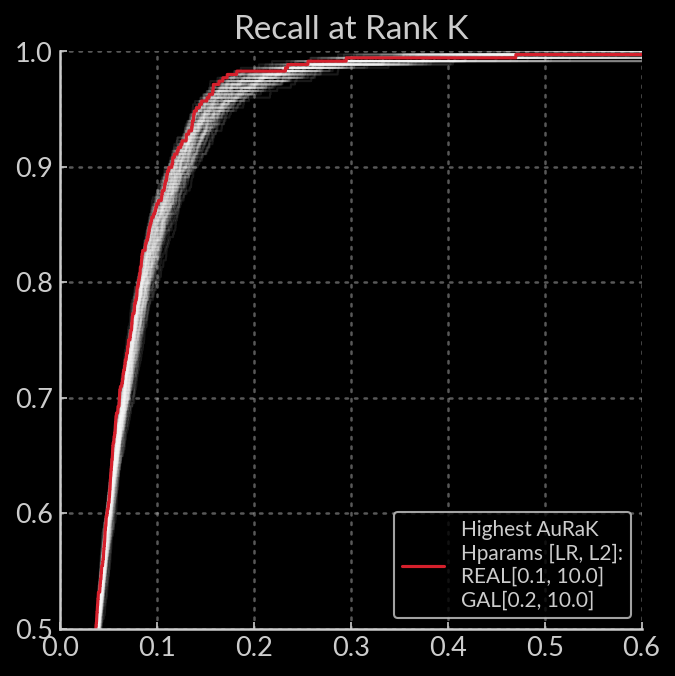

In [134]:
fig, ax = plt.subplots(facecolor='black', figsize=(5,5))
ax.set_facecolor('black')
x=np.linspace(0,1, len(R_at_K_lists[0]))

for recall_at_k_list in R_at_K_lists:
    ax.plot(x, 
        recall_at_k_list, color='w', lw=1, alpha=0.1
       )
    
ax.plot(x, 
    R_at_K_lists[BEST_INDEX], label=f'Highest AuRaK \nHparams [LR, L2]:\nREAL{hp_real[BEST_INDEX]}\nGAL{hp_gal[BEST_INDEX]}', 
        color=vra_colors['red'],
        lw=1.5,  alpha=1
   )
plt.legend()
plt.ylim(0.5,1)
plt.xlim(0,0.6)
plt.title('Recall at Rank K')
plt.savefig('./hp_tuning_day1/RatK_plot_day1HPtuning.png', bbox_inches='tight')

In [85]:
pd.DataFrame(AuRaK_list,columns=['AuRaK']).sort_values(by='AuRaK', ascending=False)

,AuRaK
13,0.947166
3,0.946771
11,0.946639
10,0.946633
12,0.946618
...,...
48,0.939068
46,0.938493
86,0.938413
66,0.938274


## 2. Update models

In [86]:
    
RELATIVE_PATH = '../../data/features_and_labels_csv/update/'
X_test_unbalanced = pd.read_csv(f'{RELATIVE_PATH}X_test_unbalanced.csv', index_col=0)
y_test_unbalanced = pd.read_csv(f'{RELATIVE_PATH}y_test_unbalanced.csv', index_col=0)

X_train = pd.read_csv(f'{RELATIVE_PATH}X_train.csv', index_col = 0)
y_train = pd.read_csv(f'{RELATIVE_PATH}y_train.csv', index_col = 0)

y_train_real = y_train.map(lambda x: dict_type_to_preal[x])
y_train_gal = y_train.map(lambda x: dict_type_to_pgal[x])

y_test_real = y_test_unbalanced.map(lambda x: dict_type_to_preal[x])
y_test_gal = y_test_unbalanced.map(lambda x: dict_type_to_pgal[x])



In [87]:
real_models=sorted(glob('hp_tuning_update/models/real*_randomsplit*'))
gal_models=sorted(glob('hp_tuning_update/models/gal*_randomsplit*'))

**>>> These take A LOT longer because there are more samples in the Update model tests**

In [88]:
# The lists where we save the real and galactic scores
real_predictions = []
gal_predictions = []

# The Hyperparameter values of each scoring model
hp_real = []
hp_gal = []

# The VRA ranks (NOT the rank k) - so these are floats between 0 and 10 
ranks = []

# The ordered samples (which are proxy eyeball lists)
ordered_iball_lists = []

#####################################################
# Loop over each real model, over each galactic model
####################################################
for real_model in tqdm(real_models[:]):
    for gal_model in gal_models[:]:
        # Load the trained models
        real_scorer = load(real_model)
        gal_scorer = load(gal_model)
        
        # Get the REAL and GALACTIC scores and record the values
        REAL_PRED=real_scorer.predict_proba(X_test_unbalanced).T[1]
        GAL_PRED=gal_scorer.predict_proba(X_test_unbalanced).T[1]
        real_predictions.append(REAL_PRED)
        gal_predictions.append(GAL_PRED)
        
        # Record the values of the LR and L2 hyperparamters
        hp_real.append([real_scorer.learning_rate, real_scorer.l2_regularization])
        hp_gal.append([gal_scorer.learning_rate, gal_scorer.l2_regularization])
        
        # Calculate the ranks (and record them)
        RANKS = rank_function(REAL_PRED, GAL_PRED)
        ranks.append(RANKS)
        
        # Make neat ordered data frame and append to our list
        df_ranks = pd.DataFrame(np.vstack((RANKS, y_test_unbalanced.values.T[0])).T, 
                         columns = ['rank', 'type'], index=y_test_unbalanced.index)

        
        ordered_iball_lists.append(order_df_and_add_rank(df_ranks))
        


  0%|          | 0/10 [00:00<?, ?it/s]

**>>> This legit takes 3 hours**
Could probably speed up the python code but I don't think i'm gonna run it often enough for that to be worth it

### You can skip this and read the file (see below)

In [89]:
R_at_K_lists=[]
for ordered_iball_list in tqdm(ordered_iball_lists):
    recall_at_k_list = []

    for k in np.arange(1, ordered_iball_list.shape[0]+1):
        _recall = recall_at_k(ordered_iball_list, k)
        recall_at_k_list.append(_recall)

    R_at_K_lists.append(recall_at_k_list)

  0%|          | 0/100 [00:00<?, ?it/s]

In [113]:
## np.array(R_at_K_lists).tofile('./hp_tuning_update/R_at_K_lists.np')

#### To read the file instead of running the long bit of code:

In [108]:
R_at_K_lists = np.fromfile('./hp_tuning_update/R_at_K_lists.np').reshape(100, 40188)

### AuRaK and plots!

In [109]:
x=np.linspace(0,1, len(R_at_K_lists[0]))
AuRaK_list = []
for recall_at_k_list in R_at_K_lists:
    AuRaK_list.append(sum(np.ones(len(recall_at_k_list)) * np.diff(x)[0]*np.array(recall_at_k_list)))

In [110]:
aurak_df = pd.DataFrame(np.concatenate((np.array(AuRaK_list).reshape(100,1), np.array(hp_real), np.array(hp_gal)), axis=1)
             ,columns=['AuRaK', 'real_LR', 'real_L2', 'gal_LR', 'real_L2'])

In [92]:
aurak_df.to_csv('./hp_tuning_update/AuRaK_by_HP_update.csv', index=True)

In [111]:
BEST_INDEX = pd.DataFrame(AuRaK_list,columns=['AuRaK']).sort_values(by='AuRaK', ascending=False).index.values[0]

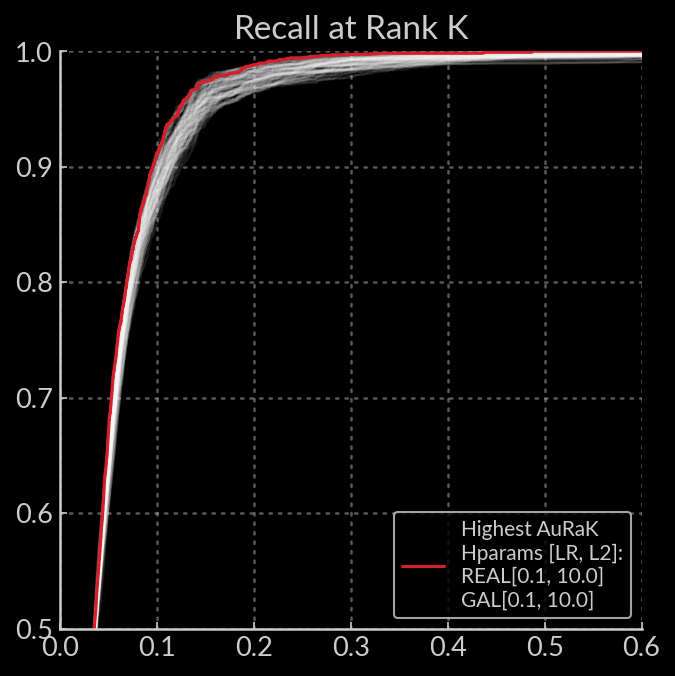

In [112]:
fig, ax = plt.subplots(facecolor='black', figsize=(5,5))
ax.set_facecolor('black')
x=np.linspace(0,1, len(R_at_K_lists[0]))

for recall_at_k_list in R_at_K_lists:
    ax.plot(x, 
        recall_at_k_list, color='w', lw=1, alpha=0.1
       )
    
ax.plot(x, 
    R_at_K_lists[BEST_INDEX], label=f'Highest AuRaK \nHparams [LR, L2]:\nREAL{hp_real[BEST_INDEX]}\nGAL{hp_gal[BEST_INDEX]}', 
        color=vra_colors['red'],
        lw=1.5,  alpha=1
   )
plt.legend()
plt.ylim(0.5,1)
plt.xlim(0,0.6)
plt.title('Recall at Rank K')
plt.savefig('./hp_tuning_update/RatK_plot_updateHPtuning.png', bbox_inches='tight')